<a href="https://colab.research.google.com/github/LuanAccioly/stellar-classification/blob/main/2VA_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PRÉ-PROCESSAMENTO**

1. **Ao menos um método de pré-processamento deve ser usado**, gerando uma nova base de dados.

1. O tipo de pré-processamento utilizado deve estar relacionado ao **contexto da aplicação**.

1. Remoção de vírgulas, espaços em branco, identificador dos padrões, etc. **não serão considerados pré-processamento válidos**.


**EXPERIMENTOS E ANÁLISE DOS RESULTADOS**

1. Os experimentos devem ser executados de acordo com o esquema abaixo para cada uma das bases de dados geradas (tanto a base de dados “brutos” quanto a base de dados pré-processadas):
   1. **Deve-se executar o 10-*fold cross-validation* 5 vezes para cada base de dados**, com cada uma das cinco execuções partindo de uma distribuição aleatória dos dados entre cada *fold*, resultando em um total de 50 experimentos por base de dados (10 x 5).
   1. Em cada um dos 50 experimentos, **os conjuntos de treinamento e teste devem ser mantido o mesmo para cada algoritmo a ser testado** (mesmo ponto de partida para cada modelo), de modo a obter-se uma avaliação justa dos resultados.
   1. Ao menos **três algoritmos** devem ser testados e comparados:
      1. **Árvore de Decisão;**
      1. **Naïve Bayes;**
      1. **K-Vizinhos Mais Próximos (K-NN) -** variando-se **3 vezes o número do parâmetro *k*;**
      1. **Rede Neural Artificial treinada por *Backpropagation***.
      1. **Outros Algoritmos de Aprendizagem Supervisionada (Classificadores) mediante validação prévia do Professor**.
1. Ao menos **duas métricas (índices) de avaliação** deverão ser empregadas na análise experimental, **além do tempo médio de execução de cada um dos algoritmos**.
1. As métricas escolhidas devem ser justificadas pela **Revisão da Literatura**.

A **análise experimental** deve ser feita de forma **empírica** (baseado nas medidas obtidas) e **através de uma discussão dos resultados experimentais**.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
from google.colab import files
from google.colab import files
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import cross_val_score, KFold, cross_validate

In [2]:
def time_converter(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60

    return f"{hours:02}h {minutes:02}m {seconds:02}s"

# Exemplo de uso:
tempo_em_segundos = 60
tempo_formatado = time_converter(tempo_em_segundos)

print(f"Tempo formatado: {tempo_formatado}")

Tempo formatado: 00h 01m 00s


In [3]:
# Transforma:
# [
#  {'accuracy': [], 'precision_weighted': []},
#  {'accuracy': [], 'precision_weighted': []}
# ]
#
# em :
#
# {
#  'accuracy': [[], []],
#  'precision_weighted': [[], []]
# }

def process_scores(data):
    processed_data = {}
    for metric_dict in data:
        for metric, values in metric_dict.items():
            if metric not in processed_data:
                processed_data[metric] = []
            processed_data[metric].append(values)
    return processed_data

In [4]:
if not Path('/content/star_classification.csv').exists():
  _ = files.upload()
df = pd.read_csv('star_classification.csv')

classes_count = df['class'].value_counts()

print(classes_count)

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64


In [5]:
# Separando 20 linhas de cada classe

galaxy_subset = df[df['class'] == 'GALAXY']
star_subset = df[df['class'] == 'STAR']
qso_subset = df[df['class'] == 'QSO']

galaxy_prediction = galaxy_subset.sample(n=20)
star_prediction = star_subset.sample(n=20)
qso_prediction = qso_subset.sample(n=20)


# Excluindo da base original as linhas retiradas para predição
prediction_df = pd.concat([galaxy_prediction, star_prediction, qso_prediction])
brute_df = df.drop(prediction_df.index)

# Verificando se a base para predição ainda está dentro da base de treino
contains = prediction_df.isin(brute_df).all().all()

print("A base para treino contém dados da base de predição"
      if contains
      else "A base para treino está limpa")

A base para treino está limpa


In [ ]:
brute_df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

In [6]:
# Separando as bases

# Base sem processamento
brute_X = brute_df.drop(columns=['obj_ID',
                                 'field_ID',
                                 'spec_obj_ID',
                                 'fiber_ID',
                                 'plate',
                                 'run_ID',
                                 'rerun_ID',
                                 'MJD',
                                 'class']).to_numpy()

# Classes
y = brute_df['class'].to_numpy()

# Base minMax. -1 : 1
minmax_scaler = MinMaxScaler(feature_range=(-1, 1))
minmax_X = minmax_scaler.fit_transform(brute_X)

# Base stardard
standard_scaler = StandardScaler()
standard_X = standard_scaler.fit_transform(brute_X)


In [ ]:
print('Base bruta:')
display(brute_X)

print('\n\nBase MinMax:')
display(minmax_X)

print('\n\nBase Standart:')
display(standard_X)

Base bruta:


array([[1.35689107e+02, 3.24946318e+01, 2.38788200e+01, ...,
        1.87937100e+01, 2.00000000e+00, 6.34793600e-01],
       [1.44826101e+02, 3.12741849e+01, 2.47775900e+01, ...,
        2.16142700e+01, 5.00000000e+00, 7.79136000e-01],
       [1.42188790e+02, 3.55824442e+01, 2.52630700e+01, ...,
        1.89482700e+01, 2.00000000e+00, 6.44194500e-01],
       ...,
       [2.24587407e+02, 1.57007074e+01, 2.11691600e+01, ...,
        1.73522100e+01, 4.00000000e+00, 1.43365600e-01],
       [2.12268621e+02, 4.66603653e+01, 2.53503900e+01, ...,
        1.86248200e+01, 4.00000000e+00, 4.55039600e-01],
       [1.96896053e+02, 4.94646428e+01, 2.26217100e+01, ...,
        1.92807500e+01, 4.00000000e+00, 5.42944200e-01]])



Base MinMax:


array([[-0.24619037,  0.00760492,  0.99822513, ...,  0.99788799,
        -0.6       , -0.81633828],
       [-0.19542848, -0.01637576,  0.99840431, ...,  0.9984505 ,
         0.6       , -0.77522221],
       [-0.21008044,  0.06827764,  0.9985011 , ...,  0.99791881,
        -0.6       , -0.81366043],
       ...,
       [ 0.24769693, -0.32238054,  0.99768491, ...,  0.9976005 ,
         0.2       , -0.95632202],
       [ 0.17925814,  0.28594879,  0.99851851, ...,  0.99785431,
         0.2       , -0.86754138],
       [ 0.09385362,  0.34105031,  0.9979745 , ...,  0.99798512,
         0.2       , -0.84250167]])



Base Standart:


array([[-0.43468691,  0.42557372,  0.05972787, ...,  0.00394511,
        -0.95247698,  0.0796659 ],
       [-0.34000511,  0.36344673,  0.08801008, ...,  0.09281668,
         0.93798733,  0.27721496],
       [-0.36733416,  0.58275916,  0.10328702, ...,  0.00881506,
        -0.95247698,  0.09253211],
       ...,
       [ 0.48651881, -0.42932289, -0.02553887, ..., -0.04147438,
         0.30783256, -0.59290944],
       [ 0.35886579,  1.14668198,  0.10603478, ..., -0.00137636,
         0.30783256, -0.16634798],
       [ 0.19956806,  1.28943404,  0.02016952, ...,  0.019291  ,
         0.30783256, -0.04604049]])

In [ ]:
# Instanciando modelos
rf = RandomForestClassifier()
dt = tree.DecisionTreeClassifier()
nb = GaussianNB()
knn = KNeighborsClassifier()

In [ ]:
def generate_results_table(algorithms, scores, times):
    total_time = [round(sum(fold_times), 3) for fold_times in times]
    avg_seed_time = [round(np.mean(fold_times), 3) for fold_times in times]
    df_resultados = pd.DataFrame({
        'Algoritmo': algorithms,
        'Acurácia média': scores['accuracy'],
        'Precisão média': scores['precision_weighted'],
        'Recall médio': scores['recall_weighted'],
        'F1 médio': scores['f1_weighted'],
        'Tempo médio por seed': avg_seed_time,
        'Tempo total': total_time
    })

    return df_resultados

In [ ]:
def plot_algorithm_comparison(algorithms_names,
                              databases,
                              inter_bases_scores_values,
                              scoring_name):
    bar_width = 0.30
    index = np.arange(len(algorithms_names))

    plt.figure(figsize=(13, 5))

    # Loop para cada conjunto de colunas (diferentes bases)
    for i, scores in enumerate(inter_bases_scores_values):
        bars = plt.bar(index + i * bar_width, scores, bar_width, label=f'{databases[i]}')
        for bar, score in zip(bars, scores):
            plt.text(bar.get_x() + bar.get_width() / 2,
                     bar.get_height() / 2,
                     f'{score:.3f}',
                     ha='center',
                     va='center',
                     fontsize='x-large',
                     fontweight='bold',
                     color='white'
                     )

    plt.xlabel('Algoritmos')
    plt.ylabel(scoring_name)
    plt.title(scoring_name.upper())
    plt.xticks(index + (len(databases) - 1) * bar_width / 2, algorithms_names)
    plt.legend()
    plt.show()

In [ ]:
# Definindo seeds para garantir mesmo conjunto aleatório para cada algoritmo
seeds = [2, 4, 8, 16, 32]

folds=10
algorithms = [rf, nb, knn, dt]
databases = [brute_X, minmax_X, standard_X]

# Responsável por unir valores dos scores
inter_bases_scores_values = []

algorithms_names = ['Random Forest',
                    'NaiveBayes',
                    'Knn',
                    'Decision Tree']


databases_names = ['Base bruta',
                   'Base minMax',
                   'Base standard']

scoring_names = ['accuracy',
                 'precision_weighted',
                 'recall_weighted',
                 'f1_weighted']


# Para cada base de dados (brute_X, processed_X)
for index, X in enumerate(databases):
  score_values = {'accuracy': [],
                  'precision_weighted': [],
                  'recall_weighted': [],
                  'f1_weighted': []}
  time_values = []
  total_time_values = []

  start_database_time = time.time()

  # Ao menos três algoritmos devem ser testados e comparados
  for algorithm in algorithms:
    algorithm_times = []
    algorithm_scores = {'accuracy': [],
                        'precision_weighted': [],
                        'recall_weighted': [],
                        'f1_weighted': []}

    start_algorithm_time = time.time()

    # Cinco execuções partindo de uma distribuição aleatória
    # dos dados entre cada fold
    for seed in seeds:
      knn.n_neighbors = seed

      # Definindo a aleatoriedade dos folds
      kf = KFold(n_splits=folds,
                 shuffle=True,
                 random_state=seed)

      start_seed_time = time.time()

      scores = cross_validate(algorithm,
                              X,
                              y,
                              cv=kf,
                              scoring=scoring_names)

      final_seed_time = time.time()

      algorithm_times.append(final_seed_time - start_seed_time)

      # Populando o dicionário dos scores a nível de seed
      for key in algorithm_scores:
                algorithm_scores[key].append(scores['test_' + key].mean())

    final_algorithm_time = time.time()

    total_time_values.append(final_algorithm_time - start_algorithm_time)
    time_values.append(algorithm_times)

    # Populando o dicinário dos scores a nível de algoritmo
    for key in score_values:
            score_values[key].append(np.mean(algorithm_scores[key]))

  final_databse_time = time.time()

  # Definindo os scores para a base de dados em execução
  inter_bases_scores_values.append(score_values)


  print('\n\n{}'.format(databases_names[index]))
  print('Tempo total: {}'.format((final_databse_time - start_database_time) / 60))
  display(generate_results_table(algorithms_names,  score_values, time_values))




Base bruta
Tempo total: 38.063210705916084


,Algoritmo,Acurácia média,Precisão média,Recall médio,F1 médio,Tempo médio por seed,Tempo total
0,Random Forest,0.978829,0.978726,0.978829,0.978694,416.122,2080.612
1,NaiveBayes,0.750596,0.794417,0.750596,0.694432,3.377,16.886
2,Knn,0.816218,0.816819,0.816218,0.802933,14.091,70.453
3,Decision Tree,0.964801,0.964881,0.964801,0.964835,23.168,115.840




Base minMax
Tempo total: 35.23273895978927


,Algoritmo,Acurácia média,Precisão média,Recall médio,F1 médio,Tempo médio por seed,Tempo total
0,Random Forest,0.977769,0.977657,0.977769,0.977631,379.574,1897.870
1,NaiveBayes,0.763092,0.805737,0.763092,0.718866,3.573,17.865
2,Knn,0.902516,0.905992,0.902516,0.901157,17.304,86.521
3,Decision Tree,0.963368,0.963447,0.963368,0.963400,22.341,111.706




Base standard
Tempo total: 38.466149695714314


,Algoritmo,Acurácia média,Precisão média,Recall médio,F1 médio,Tempo médio por seed,Tempo total
0,Random Forest,0.978767,0.978663,0.978767,0.978632,414.971,2074.855
1,NaiveBayes,0.763260,0.805852,0.763260,0.719109,3.366,16.828
2,Knn,0.914789,0.916956,0.914789,0.913899,20.085,100.425
3,Decision Tree,0.964659,0.964744,0.964659,0.964694,23.172,115.859


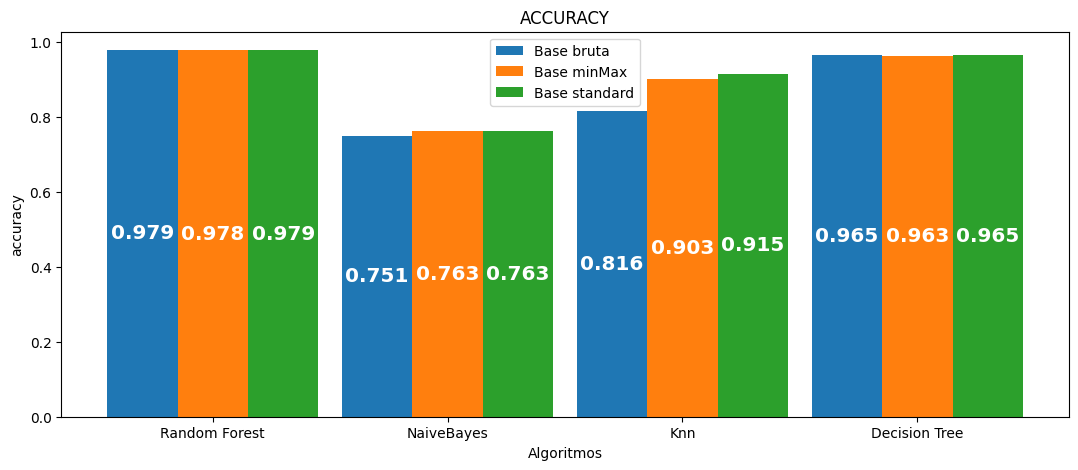

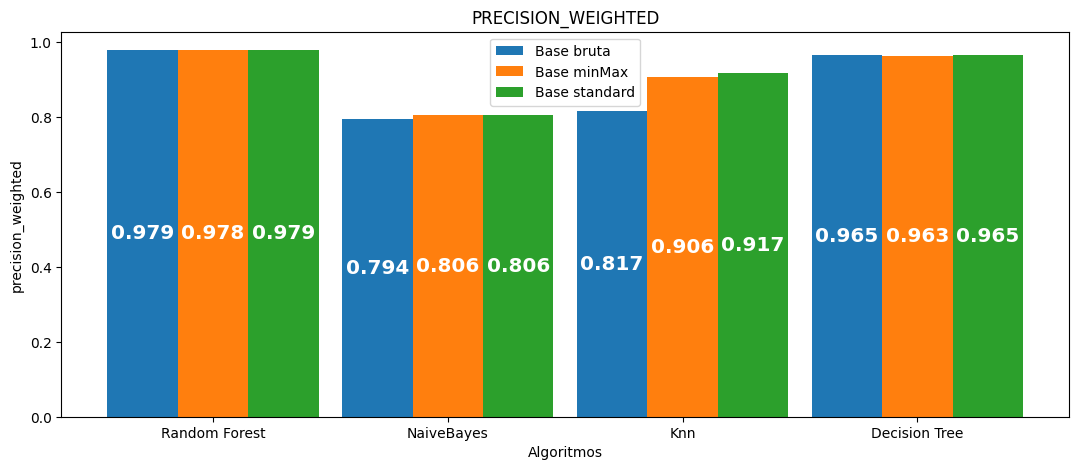

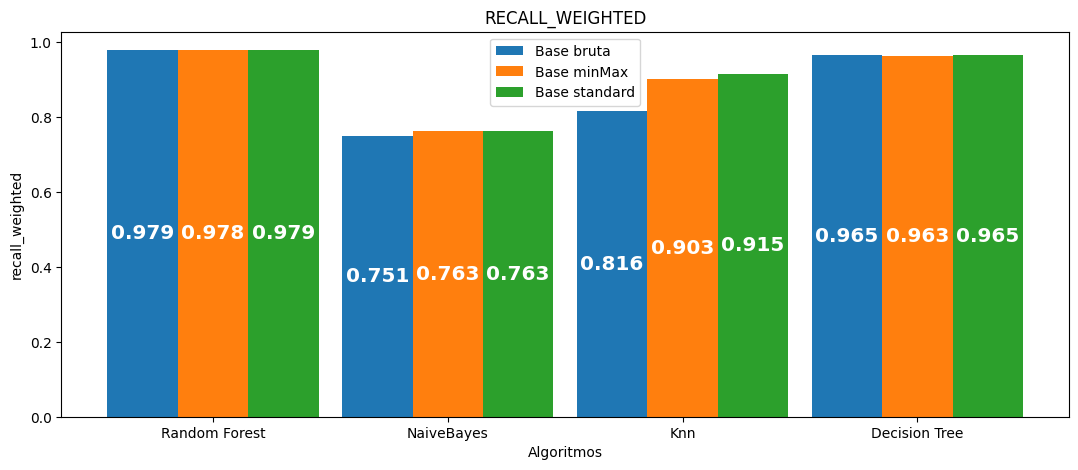

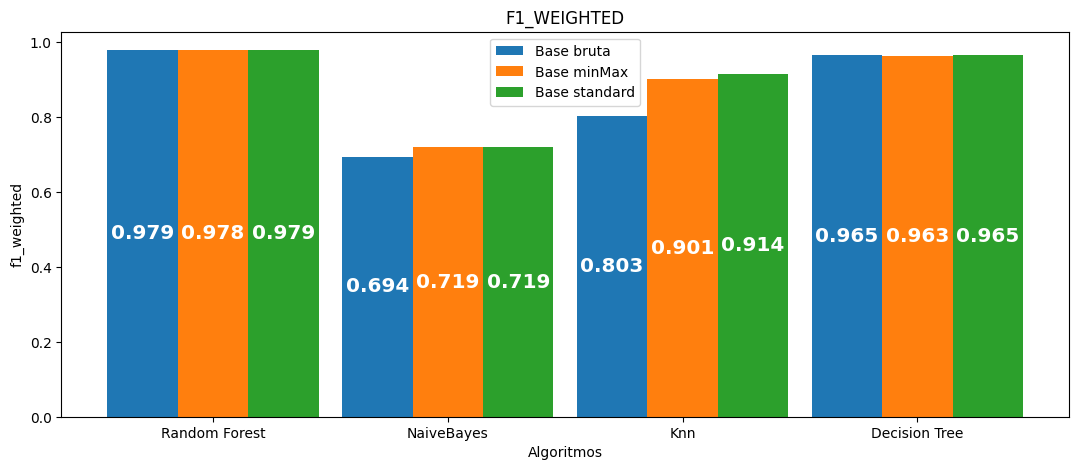

In [ ]:
processed_scores = process_scores(inter_bases_scores_values)

for score in scoring_names:

  print('\n\n')
  plot_algorithm_comparison(algorithms_names,
                            databases_names,
                            processed_scores[score],
                            score)